# Mini-project 2

In [1]:
import torch
from torch import tensor
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# Disable autograd globally
torch.set_grad_enabled(False)

## Generate the dataset

The label of each datapoint is of the kind:

\begin{equation}
x=(x_1, x_2) 
\mapsto 
\begin{cases}
0 & \textrm{if} \; \sqrt{(x_1 - c_1)^2 + (x_2 - c_2)^2} < 1 / \sqrt{2 \pi} \\
1 & \textrm{if} \; \sqrt{(x_1 - c_1)^2 + (x_2 - c_2)^2} > 1 / \sqrt{2 \pi}
\end{cases}
\end{equation}

where $(x_1, x_2)$ are the coordinates of the datapoint $x$ and $(c_1, c_2)$ are the coordinates of the center $c$ of the circonference.

In [3]:
# The following method generates the specified dataset

def sample_generator (dim, center):
    
    # dim -> dimension of the sample
    # center -> center of the radius
    
    # Generate same randomly distributed datapoints in [0,1]^2
    data = torch.empty(dim, 2).uniform_()
    
    # Define radius
    radius = 1 / math.sqrt(2 * math.pi)
    
    # Compute the length of the vector and assign labels
    label = ((data[:,0]-center[0]).pow(2) + (data[:,1]-center[1]).pow(2)).pow(0.5) > radius
    
    # label 0 -> inside the radius
    # label 1 -> outside the radius
    
    # Allocate empty tensor
    target = torch.empty(dim, 2).zero_()
    
    # Assign labels
    for i in range(len(label)):
        if label[i] == 0:
            target[i][0] = 1 # [1,0] -> Inside the radius
        else:
            target[i][1] = 1 # [0,1] -> Outside the radius
    
    return data, target, label

In [4]:
# Generate training and testing dataset
center = (0.5, 0.5)
N      = 1000
train_input, train_target, train_label = sample_generator (N, center)
test_input, test_target, test_label    = sample_generator (N, center)

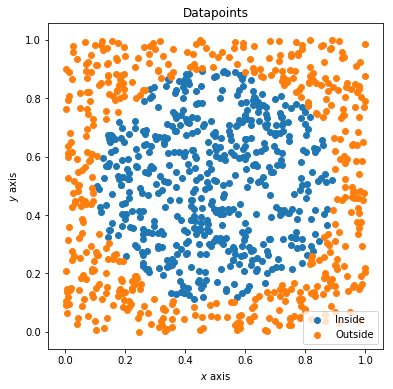

In [5]:
# Plot the training dataset
plt.figure(figsize=(6,6))
inside_circ  = train_input[train_label == 0] # Points inside the radius
outside_circ = train_input[train_label == 1] # Points outside the radius
plt.scatter(inside_circ[:,0].numpy(), inside_circ[:,1].numpy(), label='Inside')
plt.scatter(outside_circ[:,0].numpy(), outside_circ[:,1].numpy(), label='Outside')
plt.legend()
plt.xlabel('$x$ axis')
plt.ylabel('$y$ axis')
plt.title('Datapoints')
plt.show()

In [6]:
# Data standardization
mean = train_input.mean(0)
std  = train_input.std(0)
train_input = train_input.sub(mean).div(std)

mean = test_input.mean(0)
std  = test_input.std(0)
test_input = test_input.sub(mean).div(std)

## Basic class

In [7]:
class Module(object):
    def __init__(self):
        self.test = 0

    def forward(self, *input):
        raise NotImplementedError

    def backward(self, *gradwrtoutput):
        raise NotImplementedError

    def param(self):
        return []

In [8]:
testClass = Module()
testClass.test

0

## Activation function class

### 1. ReLU

The ReLU activation function and its derivative is defined as:

\begin{equation}
ReLU(x) = 
\begin{cases}
x & \textrm{if} \; x > 0 \\
0 & \textrm{otherwise}
\end{cases}
\quad
\Rightarrow
\quad
\frac{d}{dx} ReLU(x) = 
\begin{cases}
1 & \textrm{if} \; x > 0 \\
0 & \textrm{otherwise}
\end{cases}
\end{equation}

In [9]:
# The ReLU class defines the ReLU activation function class

class ReLU(Module):
    def __init__(self):
        super(ReLU, self).__init__()

    # Apply the function for the forward pass
    def forward (self, input):
        # For each element, return 0 if the element is negative, otherwise nothing changes
        return torch.clamp(input, 0).float()

    # Derivative of the activation function for the backward pass
    def backward (self, input):
        # For each element, return 0 if the element is negative, otherwise returns 1
        return torch.clamp(input, 0).gt(0).float()
    
    def print_activation (self):
        return 'ReLU'
       
# Note the all the values must always float-type tensors

In [10]:
testReLU = ReLU()
testReLU

### 2. $\tanh$

The $\tanh$ activation function and its derivative is defined as:

\begin{equation}
\tanh(x) = 
\frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}
\quad
\Rightarrow
\quad
\frac{d}{dx} \tanh(x) = \frac{1}{\cosh^2(x)}
\end{equation}

In [11]:
# The Tanh class defines the tanh activation function class

class Tanh(Module):
    def __init__(self):
        super(Tanh, self).__init__()
    
    # Apply the function for the forward pass
    def forward (self, input):
        # For each element, compute the tanh
        return input.tanh().float()

    # Derivative of the activation function for the backward pass
    def backward (self, input):
        # For each element, compute the derivative of tanh
        return 1 / input.cosh().pow(2).float()
    
    def print_activation (self):
        return 'Tanh'
    
# Note the all the values must always float-type tensors

In [12]:
testTanh = Tanh()
testTanh

### 3. Linear

With a fully connected layer we have:
    
\begin{equation}
\textrm{linear}(x) = x
\quad
\Rightarrow
\quad
\frac{d}{dx} \textrm{linear}(x) = 1
\end{equation}

In [13]:
# The Linear class defines a fully connected layer

class Linear (Module):
    def __init__(self):
        super(Linear, self).__init__()

    # Apply the function for the forward pass
    def forward (self, input):
        return input.float()

    # Derivative of the activation function for the backward pass
    def backward (self, input):
        return torch.empty(input.shape).fill_(1).float()
    
    def print_activation (self):
        return 'Linear'
    
# Note the all the values must always float-type tensors

In [14]:
testLinear = Linear()
testLinear

### 4. Sigmoid

The sigmoid activation function is defined as:
    
\begin{equation}
\sigma (x) = \frac{1}{1 + e^{-x}}
\quad
\Rightarrow
\quad
\frac{d}{dx} \sigma (x) = \frac{e^{-x}}{\left( 1 + e^{-x} \right)^2}
\end{equation}

In [15]:
# The Sigmoid class defines a sigmoid activation function

class Sigmoid (Module):
    def __init__(self):
        super(Sigmoid, self).__init__()

    # Apply the function for the forward pass
    def forward (self, input):
        return input.sigmoid().float()

    # Derivative of the activation function for the backward pass
    def backward (self, input):
        return input.sigmoid().mul(1 - input.sigmoid()).float()
    
    def print_activation (self):
        return 'Sigmoid'
    
# Note the all the values must always float-type tensors

In [16]:
testSigmoid = Sigmoid()
testSigmoid

## Loss function class

### 1. MSE

The MSE loss function is defined as:

\begin{equation}
\ell = \| v - t \|_2^2 = \sum_i (v_i - t_i)^2
\quad
\Rightarrow
\quad
\frac{d}{dv} \ell = 2 (v - t)
\end{equation}

where $t$ is the target and $v$ is the input tensor.

In [17]:
# The MSE class defines the Mean Square Error loss criterion
# Check practical 3

class MSELoss(object):
    def __init__(self):
        super(MSELoss, self).__init__()
        
    # Apply the MSE loss
    def loss (self, v, t):
        return (v - t.resize_(v.size())).pow(2).sum()
    
    # Apply the derivative of the MSE loss
    def dloss (self, v, t):
        return 2 * (v - t.resize_(v.size()))
    
    # Notice that is is necessary to resize t in order to match the shape of v
    # Otherwise, with 1D target there are errors

In [18]:
testMSELoss = MSELoss()
testMSELoss

### 2.Binary Cross Entropy Loss Function

\begin{equation}
\ell = -t \log(y) - (1-t) \log(1-\sigma(v))
 \\
\frac{d}{dv} \ell = -\frac{t}{v} + (1-t) \frac{1}{1-\sigma(v)} \sigma'(v)
\end{equation}

In [62]:
class CELoss(object):
    def __init__(self):
        super(CELoss, self).__init__()
        
    # Apply the MSE loss
    def loss (self, v, t):
        return (-t.resize_(v.size())*torch.log(v) - (1-t.resize_(v.size()))*torch.log(1-torch.sigmoid(v))).sum()
        #return (v - t.resize_(v.size())).pow(2).sum()
    
    # Apply the derivative of the MSE loss
    def dloss (self, v, t):
        return -t.resize_(v.size())/v - (1-t.resize_(v.size()))*(-1/(1-torch.sigmoid(v)))*(torch.exp(-v)/(1+torch.exp(-v))**2)
        #return 2 * (v - t.resize_(v.size()))
        
    
    # Notice that is is necessary to resize t in order to match the shape of v
    # Otherwise, with 1D target there are errors

In [76]:
testCELoss = CELoss()
testCELoss

## Layer class

In [20]:
# The Layer class defines the structure of a layer of neurons:

class Layer(Module):
    def __init__(self, in_nodes, out_nodes, activ_fun):
        super(Layer, self).__init__()
        
        # Number of nodes before the activation
        self.in_nodes  = in_nodes
        
        # Number of nodes after the activation
        self.out_nodes = out_nodes
        
        # Activation function
        self.activ_fun = activ_fun
        
        # Initialize weights
        # Xavier initialization with Var[w_l] = 2 / (N_l + N_l-1)
        self.w = torch.empty(in_nodes, out_nodes).normal_(0, np.sqrt(2 / (in_nodes + out_nodes)))
        
        # Initialize biases
        # Biases initialized at zero
        self.b = torch.empty(out_nodes).zero_()
        
        # Initialize error
        self.error = 0

    # Define the forward pass
    # data_input is the tensor with the data as input
    def forward(self, data_input):   
        # Multiply with the weights and then add the biases
        return data_input.mm(self.w).add(self.b)

    def backward(self, input):
        return input

In [21]:
testLayer = Layer(5, 10, ReLU)
testLayer

## Sequential class

In [22]:
# The sequential class combines different layers into the same network

class Sequential(Module):
    def __init__(self, *args):
        super(Sequential, self).__init__()
        
        # Combine all the layers
        self.layers = [layer for layer in args]
        
        # For each layer store the values after applying the weights and biases
        self.results = []
        
        # For each layer store the values after applying the activation function
        self.post_activ = []
        
        # For each layer allocate the derivatives with respect to the weights
        self.dl_dw = [torch.empty(layer.w.shape).zero_() for layer in self.layers]
        
        # For each layer allocate the derivatives with respect to the biases
        self.dl_db = [torch.empty(layer.b.shape).zero_() for layer in self.layers]
    
    # Define the forward pass
    # Check practical 3
    def forward(self, data_input):
        # data_input -> train_input or test_input tensor
        
        # Initially set the input tensor equal to the output tensor
        # The output tensor will be over-written layer after layer
        data_output = data_input
        
        # Initially the values post-activation are the same as the input
        self.post_activ = [data_input]
        
        # Initially there are no values pre-activation 
        self.results = []
        
        for layer in self.layers:
            # Multiply the data with the weights and add the biases
            data_output = layer.forward(data_output)
            
            # Store the data with the weights and biases added
            self.results.append(data_output)
            
            # Apply the activation function
            data_output = layer.activ_fun.forward(data_output)
            
            # Store the data after applying the activation function
            self.post_activ.append(data_output)
         
        # At the end of the forward pass return the processed output
        return data_output
    
    # Backward pass
    # Check practical 3 and back-propagation algorithm
    def backward(self, loss, target):
        # loss -> loss criterion (such as MSE)
        # target -> target tensor with true labels
        
        # Store values for local usage
        dl_db, dl_dw = self.dl_db, self.dl_dw
        
        # Now repeat the same operations for each layer l < L
        
        for k in range(1, len(self.layers)+1):  
            
            # Output of the last layer
            s_l = self.results[-k]
            # Compute the derivative of the last activation function
            dsigma = self.layers[-k].activ_fun.backward(s_l)
            
            # Output of the last layer after the activation function
            x_l_current = self.post_activ[-k]
            
            # Take the weights from layer l+1
            w = self.layers[-k + 1].w
            # Compute the derivative of the loss with respect to the output
            if k == 1:
                dl_dx = loss.dloss(x_l_current, target)
            else:
                dl_dx = (dl_ds).mm(w.t())
            
            # Compute the derivative of the loss with respect to the activation
            dl_ds = dsigma * dl_dx
            
            # Store derivatives of the biases
            dl_db[-k].add_(dl_ds.sum(0))
            
            # Store derivatives of the weights
            x_l_previous = self.post_activ[-(k+1)]
            dl_dw[-k].add_(x_l_previous.t().mm(dl_ds))
        
        return dl_dw, dl_db
    
    # This function print the structure of the network
    def print_structure(self):
        cont = 0
        for layer in self.layers:
            print('(Layer {:d}) in neurons ({:d}) -> {:s} -> out neurons ({:d})'.format(cont, layer.in_nodes, layer.activ_fun.print_activation(), layer.out_nodes))
            cont = cont + 1

## Optimizer

In [23]:
class Optimizer (object):
    def __init__(self):
        self.test = 0

    def optimize (self, *input):
        raise NotImplementedError

    def remove_grad (self, *gradwrtoutput):
        raise NotImplementedError

    def update_parameter (self, *new_params):
        raise NotImplementedError

### 1. Plain SGD

In the standard SGD, the update step is defined as:

\begin{align}
w_{t+1} = w_t - \eta g_t
\qquad
\textrm{with}
\qquad
g_t = \sum_{b=1}^B \nabla \ell_{n(t,b)} (w_t)
\end{align}

In [24]:
class SGD (Optimizer):
    def __init__(self, learning_rate):
        super(SGD, self).__init__()
        self.learning_rate = learning_rate

    # Optimize parameters
    def optimize (self, model):
        for k, layer in enumerate(model.layers):
            # Optimize weights
            layer.w = layer.w - self.learning_rate * model.dl_dw[k]
            
            # Optimize biases
            layer.b = layer.b - self.learning_rate * model.dl_db[k]

    # Initialize gradiets at zero again for a new iteration
    def zero_grad (self, model):
        model.dl_dw = [torch.empty(x.shape).zero_() for x in model.dl_dw]
        model.dl_db = [torch.empty(x.shape).zero_() for x in model.dl_db]

    # Change learning rate
    # Hence, it is possible to set a big step at the beginning a small step at the end
    def update_parameter (self, new_learning_rate):
        self.learning_rate = new_learning_rate

In [25]:
testSGD = SGD(0.05)
testSGD

### 2. SGD with momentum

In the standard SGD, the update step is defined as:

\begin{equation}
\begin{aligned}
u_t &= \gamma u_{t-1} + \eta g_t \\
w_{t+1} &= w_t - u_t
\end{aligned}
\end{equation}

In [26]:
class SGD_momentum (Optimizer):
    def __init__(self, learning_rate, momentum):
        super(SGD_momentum, self).__init__()
        self.learning_rate = learning_rate
        self.momentum      = momentum

    # Optimize parameters
    def optimize (self, model):
        for k, layer in enumerate(model.layers):
            # Optimize weights
            temp_w  = layer.w * self.momentum + self.learning_rate * model.dl_dw[k]
            layer.w = layer.w - temp_w
            
            # Optimize biases
            temp_b  = layer.b * self.momentum + self.learning_rate * model.dl_db[k]
            layer.b = layer.b - temp_b

    # Initialize gradiets at zero again for a new iteration
    def zero_grad (self, model):
        model.dl_dw = [torch.empty(x.shape).zero_() for x in model.dl_dw]
        model.dl_db = [torch.empty(x.shape).zero_() for x in model.dl_db]

    # Change learning rate
    def update_parameter (self, new_learning_rate):
        self.learning_rate = new_learning_rate

In [27]:
testSGD_momentum = SGD_momentum(0.05, 0.8)
testSGD_momentum

## Additional functions

In [28]:
# To compute the number of missclassified datapoints and the accuracy

def compute_accuracy (output, target_data):
    
    # Compute number of samples
    nb_samples = float(output.size(0))
    
    # Compute the position of the maximum in the output and target
    pos_output = output.argmax(1)
    pos_target = target_data.argmax(1)
    
    # Compute the number of errors
    nb_error = float(pos_output.ne(pos_target).sum())
    
    # Compute accuracy
    accuracy = 1 - nb_error / nb_samples
    
    return int(nb_error), accuracy

# Note the "nb_samples" and "nb_error" must be converted to a float because otherwise the output is a tensor

In [29]:
# To train the network without mini-batches and store the results

def training (model, optimization_method, criterion, learning_rate, epoch, *args):
    
    # If there are optional arguments, then update the learning rate
    if args:
        final_learning_rate = args[0]
        update_rate         = args[1]
        rates               = np.linspace(learning_rate, final_learning_rate, update_rate)
        learning_rate       = rates[0]
        cont                = 0
    
    # Training cycle
    for e in range(epoch):
        train_loss = 0
        test_loss  = 0
        
        # Initialize gradient for each layer
        optimization_method.zero_grad(model)
        
        # Forward propagation
        output = model.forward(train_input)
            
        # Compute loss
        loss = criterion.loss(output, train_target)
        
        # Backward propagation
        model.backward(criterion, train_target)

        # Optimize
        optimization_method.optimize(model)
    
        # Compute statistics for training
        train_loss = train_loss + float(loss)
        train_errors, train_accuracy = compute_accuracy (output, train_target)
    
        # Compute statistics for testing
        test_output = model.forward(test_input)
        loss = criterion.loss(test_output, test_target)
        test_loss = test_loss + float(loss)
        test_errors, test_accuracy = compute_accuracy (test_output, test_target)
    
        # Store results
        df_no_batches.loc[e] = [train_loss, train_errors, train_accuracy, test_loss, test_errors, test_accuracy]
        
        # Update rate
        if args:
            if e == int(epoch / update_rate):
                cont = cont + 1
                learning_rate = rates[cont]
                optimization_method.update_parameter(learning_rate)

In [30]:
# To train the network with mini-batches and store the results

def training_with_batches (model, optimization_method, criterion, learning_rate, epoch, mini_batch_size, *args):
    
    # If there are optional arguments, then update the learning rate
    if args:
        final_learning_rate = args[0]
        update_rate         = args[1]
        rates               = np.linspace(learning_rate, final_learning_rate, update_rate)
        learning_rate       = rates[0]
        cont                = 0
    
    # Training cycle
    for e in range(epoch):
        train_loss = 0
        test_loss  = 0
        train_errors_total = 0
    
        # For each mini-batch
        for b in range(0, train_input.size(0), mini_batch_size):
        
            if (train_input.size(0) - b) < mini_batch_size:
                mini_batch_size = train_input.size(0) - b
        
            # Initialize gradient for each layer
            optimization_method.zero_grad(model)
        
            # Forward propagation
            output = model.forward(train_input.narrow(0, b, mini_batch_size))
        
            # Compute loss
            loss = criterion.loss(output, train_target.narrow(0, b, mini_batch_size))
        
            # Backward propagation
            model.backward(criterion, train_target.narrow(0, b, mini_batch_size))
    
            # Optimize
            optimization_method.optimize(model)
    
            # Compute statistics for training
            train_loss = train_loss + float(loss)
        
            train_errors, _ = compute_accuracy (output, train_target.narrow(0, b, mini_batch_size))
            train_errors_total = train_errors_total + train_errors
    
        train_accuracy_total = 1 - train_errors_total / float(train_input.size(0))
    
        # Compute statistics for testing
        test_output = model.forward(test_input)
        loss = criterion.loss(test_output, test_target)
        test_loss = test_loss + float(loss)
        test_errors, test_accuracy = compute_accuracy (test_output, test_target)
    
        # Store results
        df_with_batches.loc[e] = [train_loss, train_errors_total, train_accuracy_total, test_loss, test_errors, test_accuracy]
    
        # Update rate
        if args:
            if e == int(epoch / update_rate):
                cont = cont + 1
                learning_rate = rates[cont]
                optimization_method.update_parameter(learning_rate)

## Training without mini-batches

In [63]:
# Check the network structure
model = Sequential(
    Layer(2, 25, ReLU()),
    Layer(25, 25, ReLU()),
    Layer(25, 25, ReLU()),
    Layer(25, 2, Sigmoid())
)

# Print the network structure 
model.print_structure()

# Note the in the final layer there are only two nodes relative two the two classes: inside or outside
# Note that with Tanh() the output is less stable

(Layer 0) in neurons (2) -> ReLU -> out neurons (25)
(Layer 1) in neurons (25) -> ReLU -> out neurons (25)
(Layer 2) in neurons (25) -> ReLU -> out neurons (25)
(Layer 3) in neurons (25) -> Sigmoid -> out neurons (2)


In [64]:
# Create the dataframe to store the values in the no-mini-batches case
df_no_batches = pd.DataFrame(data=[],
                             columns=['Train Loss', 'Train Errors', 'Train Accuracy',
                                      'Test Loss', 'Test Errors', 'Test Accuracy']
                            )

In [65]:
# Training parameters
epoch               = 2000
criterion           = CELoss()
learning_rate       = 5e-4
momentum            = 0.8
optimization_method = SGD (learning_rate)

# Optional training arguments
final_learning_rate = 5e-5
update_rate         = 10 # update the rate 10 times

# With Sigmoid() use 5e-4 as initial learning rate, with Tanh() use 5e-5

In [66]:
# Start training and testing
training (model, optimization_method, criterion, learning_rate, epoch)

In [67]:
# Print results at the beginning
display(df_no_batches.head(5))

# Print results at the end
display(df_no_batches.tail(5))

,Train Loss,Train Errors,Train Accuracy,Test Loss,Test Errors,Test Accuracy
0,1621.696533,510.0,0.490,1552.580566,493.0,0.507
1,1554.887085,499.0,0.501,1504.744629,461.0,0.539
2,1506.830811,466.0,0.534,1465.969849,412.0,0.588
3,1467.700806,423.0,0.577,1435.276123,377.0,0.623
4,1436.690430,384.0,0.616,1410.939575,346.0,0.654


,Train Loss,Train Errors,Train Accuracy,Test Loss,Test Errors,Test Accuracy
1995,889.540588,65.0,0.935,796.284790,24.0,0.976
1996,714.588989,5.0,0.995,723.886780,12.0,0.988
1997,711.427002,6.0,0.994,761.332275,22.0,0.978
1998,708.222778,3.0,0.997,731.886597,15.0,0.985
1999,707.175476,1.0,0.999,752.780151,20.0,0.980


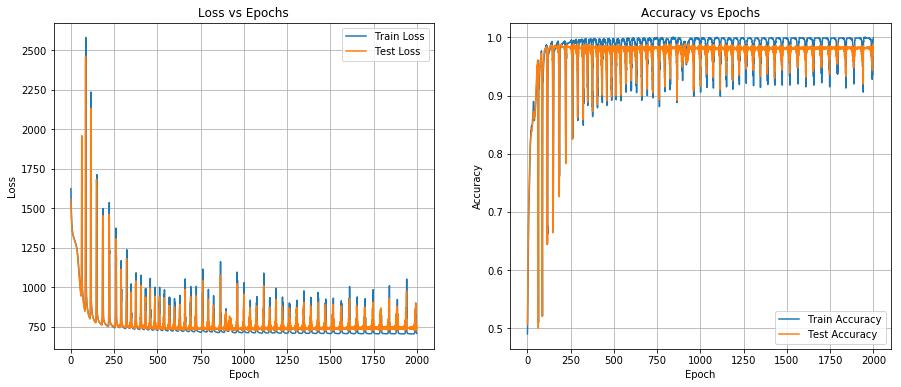

In [68]:
# Show elbow
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(df_no_batches['Train Loss'], label='Train Loss')
plt.plot(df_no_batches['Test Loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(df_no_batches['Train Accuracy'], label='Train Accuracy')
plt.plot(df_no_batches['Test Accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.grid()

plt.show()

## Training with mini-batches

In [69]:
# Check the network structure
model = Sequential(
    Layer(2, 25, ReLU()),
    Layer(25, 25, ReLU()),
    Layer(25, 25, ReLU()),
    Layer(25, 2, Sigmoid())
)

# Print the network structure 
model.print_structure()

# Note the in the final layer there are only two nodes relative two the two classes: inside or outside

(Layer 0) in neurons (2) -> ReLU -> out neurons (25)
(Layer 1) in neurons (25) -> ReLU -> out neurons (25)
(Layer 2) in neurons (25) -> ReLU -> out neurons (25)
(Layer 3) in neurons (25) -> Sigmoid -> out neurons (2)


In [70]:
# Create the dataframe to store the values in the mini-batches case
df_with_batches = pd.DataFrame(data=[],
                               columns=['Train Loss', 'Train Errors', 'Train Accuracy',
                                        'Test Loss', 'Test Errors', 'Test Accuracy']
                              )

In [71]:
# Training parameters
epoch               = 2000
criterion           = CELoss()
learning_rate       = 5e-4
optimization_method = SGD(learning_rate)
mini_batch_size     = 100

# Optional training arguments
final_learning_rate = 5e-5
update_rate         = 10 # update the rate 10 times

# With Sigmoid() use 5e-4 as initial learning rate, with Tanh() use 5e-5

In [72]:
training_with_batches (model, optimization_method, criterion, learning_rate, epoch, mini_batch_size)

In [73]:
# Print results at the beginning
display(df_with_batches.head(5))

# Print results at the end
display(df_with_batches.tail(5))

,Train Loss,Train Errors,Train Accuracy,Test Loss,Test Errors,Test Accuracy
0,1609.081207,501.0,0.499,1574.380127,499.0,0.501
1,1549.446289,502.0,0.498,1521.296997,499.0,0.501
2,1501.982147,502.0,0.498,1480.007812,495.0,0.505
3,1464.868942,493.0,0.507,1447.284302,491.0,0.509
4,1435.366455,482.0,0.518,1421.319336,470.0,0.530


,Train Loss,Train Errors,Train Accuracy,Test Loss,Test Errors,Test Accuracy
1995,698.591187,1.0,0.999,777.633789,18.0,0.982
1996,698.524918,1.0,0.999,781.152344,19.0,0.981
1997,728.610825,9.0,0.991,888.119385,35.0,0.965
1998,815.677147,32.0,0.968,752.682800,17.0,0.983
1999,715.793488,8.0,0.992,758.846985,18.0,0.982


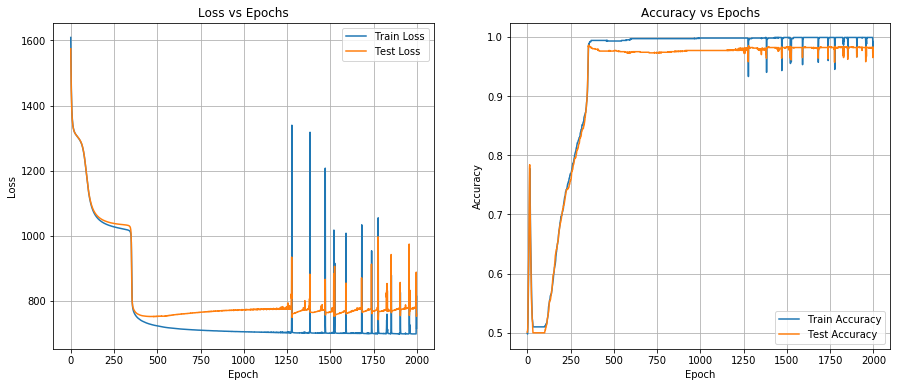

In [74]:
# Show elbow
fig = plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(df_with_batches['Train Loss'], label='Train Loss')
plt.plot(df_with_batches['Test Loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(df_with_batches['Train Accuracy'], label='Train Accuracy')
plt.plot(df_with_batches['Test Accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.grid()

plt.show()

fig.savefig('Learning.pdf')

## Conclusions

Total number of missclassified points:	18


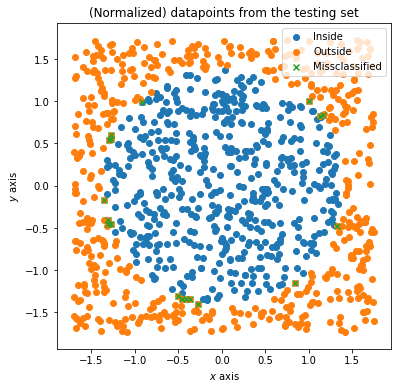

In [75]:
# Find miss-classified points
test_output     = model.forward(test_input)
pos_output      = test_output.argmax(1)
pos_target      = test_target.argmax(1)
pos_miss_class  = pos_output.ne(pos_target).numpy()
tot_miss_class  = pos_miss_class.sum()
miss_classified = torch.empty(tot_miss_class, 2).zero_()
print('Total number of missclassified points:\t{:d}'.format(tot_miss_class))

cont = 0
for i in range(len(pos_miss_class)):
    if pos_miss_class[i] == 1:
        miss_classified[cont,:] = test_input[i,:]
        cont = cont + 1

# Plot the testing dataset
fig = plt.figure(figsize=(6,6))
inside_circ  = test_input[test_label == 0] # Points inside the radius
outside_circ = test_input[test_label == 1] # Points outside the radius
plt.scatter(inside_circ[:,0].numpy(), inside_circ[:,1].numpy(), label='Inside')
plt.scatter(outside_circ[:,0].numpy(), outside_circ[:,1].numpy(), label='Outside')
plt.scatter(miss_classified[:,0].numpy(), miss_classified[:,1].numpy(), marker='x', label='Missclassified')
plt.legend(loc='best')
plt.xlabel('$x$ axis')
plt.ylabel('$y$ axis')
plt.title('(Normalized) datapoints from the testing set')
plt.show()

fig.savefig('Test_Dataset.pdf')

As we can observe, there are only 21 miss-classified datapoints which are all located along the circonference. This implies that the network is capable of capturing quite well the features of the dataset and, except for a few diffult-to-classify datapoints, it works pretty well.

# Possible extensions of the structure:

Let me know what you think:

1. Add mini-batches -> DONE
2. Add other kind of activation functions (log-soft max, leaky ReLU etc.) -> DONE
3. Add other kind of loss functions -> TO DO
4. Add drop-out layer (probably too complicated) -> TO DO